In [1]:
import sys
# sys.path.append('../mbse')
sys.path.append('/home/honam/workspace/ode/pyur5/include/pyur5')
sys.path.append('/home/honam/workspace/ode/pyur5/include/mbse')

from utils import denormalize, normalize, get_data_jax
import jax.numpy as jnp 
from jax.lax import cond
from trajax.optimizers import CEMHyperparams, ILQRHyperparams, ilqr_with_cem_warmstart, cem, ilqr
import pickle
import math
import jax
from models.models import MLP

from gym.spaces import Box
import numpy as np
from gym.envs.classic_control.pendulum import angle_normalize
import pandas as pd
import matplotlib.pyplot as plt

2023-05-16 22:47:33.500589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from models.ens_model import EnsembleModel

In [3]:
model = EnsembleModel(use_cos=True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


obs_min [ -1.          -0.99999994 -27.60719     -0.3697316   -0.5656025 ]
obs_max [ 1.          1.         29.366909    0.11000495  0.5740574 ]
action_min [-0.6999999]
action_max [0.6999999]


In [31]:
with open("../../data_pkl/data_1_False.pkl", "rb") as f:
    data = pickle.load(f)

In [40]:
(data['test']['x'][:,0] < -3.0).sum()

Array(72, dtype=int32)

In [32]:
data['test']['transitions'].reward

Array([[-97.174774],
       [-97.170074],
       [-97.17286 ],
       ...,
       [-73.95453 ],
       [-37.45271 ],
       [-22.519953]], dtype=float32)

In [30]:
data['test']['transitions'].next_obs[-5]

Array([ 2.0879235e+00,  1.0118681e+01, -3.2535335e-01, -9.4361482e-03],      dtype=float32)

In [10]:
model.step(data['test']['x'][0,:-1], data['test']['u'][0])

u before step:  [0.]
xu after normalize:  [ 1.0495945   0.02626679  0.02448151 -0.2856912  -0.00764657 -0.05065575]
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost function called
state shape:  (5,)
action shape:  (1,)
state shape:  (4,)
theta:  [0.02486362]


(Array([ 0.9898765 ,  0.0332705 ,  0.07270071, -0.128938  ,  0.00416569],      dtype=float32),
 Array(-97.174774, dtype=float32),
 False,
 {})

In [6]:
vstep = jax.vmap(model.step, in_axes=(0, 0))

In [40]:
step_1 = vstep(data['test']['x'][:,:-1], data['test']['u'])

u before step:  Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = Array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)
  batch_dim = 0
xu after normalize:  Traced<ShapedArray(float32[6])>with<BatchTrace(level=1/0)> with
  val = Array([[ 1.0495945 ,  0.02626679,  0.02448151, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0495914 ,  0.02638063,  0.02454041, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0495932 ,  0.02631347,  0.02450566, -0.2856912 , -0.00764657,
        -0.05065575],
       ...,
       [-1.2601978 ,  1.2516291 ,  0.7923746 , -1.7508601 , -0.03508765,
        -0.05065575],
       [-1.1742424 ,  1.2924764 ,  0.5003118 , -1.7516361 , -0.03187837,
        -0.05065575],
       [-1.0561429 ,  1.3389567 ,  0.28491655, -1.752323  , -0.02988534,
        -0.05065575]], dtype=float32)
  batch_dim = 0
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost functio

In [18]:
x = data['valid']['x'][:,:-1]
u = data['valid']['u']

In [16]:
n_horizon = 10

In [45]:
next_u

Array([1.], dtype=float32)

In [19]:
next_x = x
next_u = u
for i in range(n_horizon):
    next_x, *rest = vstep(next_x, next_u)
    next_x = next_x[1:]
    next_u = next_u[1:]

u before step:  Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = Array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)
  batch_dim = 0
xu after normalize:  Traced<ShapedArray(float32[6])>with<BatchTrace(level=1/0)> with
  val = Array([[ 1.050073  , -0.01228625,  0.00453892, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0500731 , -0.01217138,  0.00459833, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0500735 , -0.01201706,  0.00467815, -0.2856912 , -0.00764657,
        -0.05065575],
       ...,
       [-0.18052754,  1.3997313 ,  0.5010155 ,  1.5106786 ,  0.0215989 ,
        -0.05065575],
       [-0.2090822 ,  1.4051373 ,  0.4183787 ,  1.5110114 ,  0.01746411,
        -0.05065575],
       [-0.19980447,  1.4034374 ,  0.32447478,  1.5112995 ,  0.0150417 ,
        -0.05065575]], dtype=float32)
  batch_dim = 0
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost functio

In [10]:
next_x = x[0]
u = jnp.array([10])
xs = []
for i in range(5):
    next_x, *rest = model.step(next_x, u)
    xs.append(next_x)

u before step:  [10]
xu after normalize:  [ 1.05007303e+00 -1.22862505e-02  4.53891605e-03 -2.85691202e-01
 -7.64657464e-03  1.81644936e+01]
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost function called
state shape:  (5,)
action shape:  (1,)
state:  [ 0.9999982  -0.00188807 -0.01416053 -0.12999752  0.        ]
action:  [10]
state shape:  (4,)
theta:  [-0.00188807]
u before step:  [10]
xu after normalize:  [ 1.6860234 -0.5011319  0.5360384  0.8862901  3.0616546 18.164494 ]
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost function called
state shape:  (5,)
action shape:  (1,)
state:  [ 1.4085088  -0.34106216  5.333129    0.02636042  0.9339738 ]
action:  [10]
state shape:  (4,)
theta:  [-0.23757137]
u before step:  [10]
xu after normalize:  [ 2.340114   -0.96650904  1.1308671   2.2184792   5.5865173  18.164494  ]
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost function called
state shape:  (5,)
action sha

In [11]:
xs = np.stack(xs)

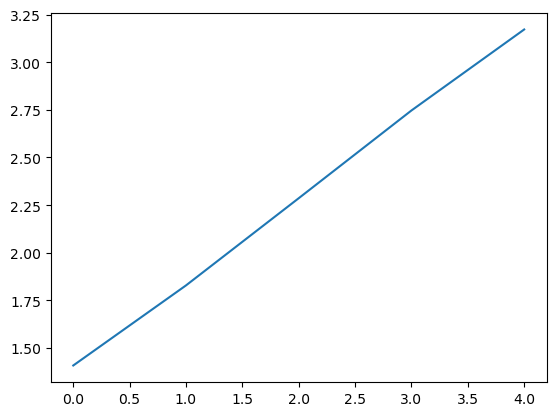

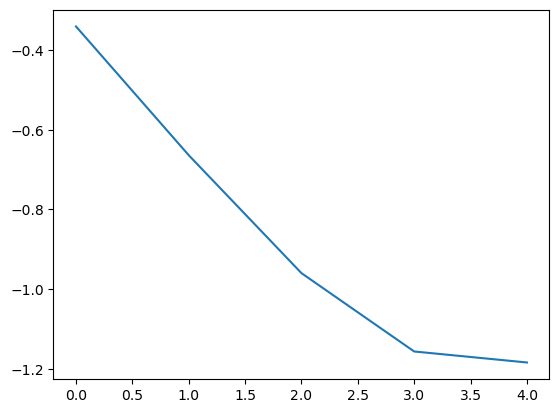

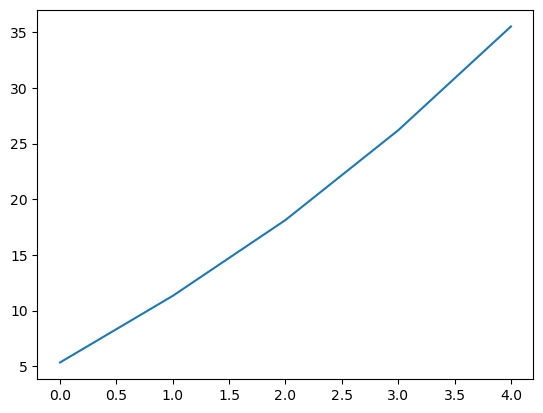

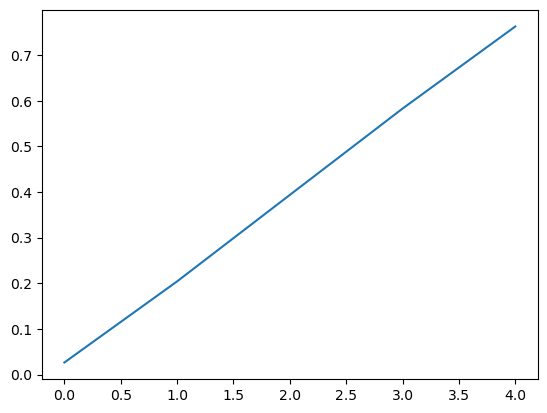

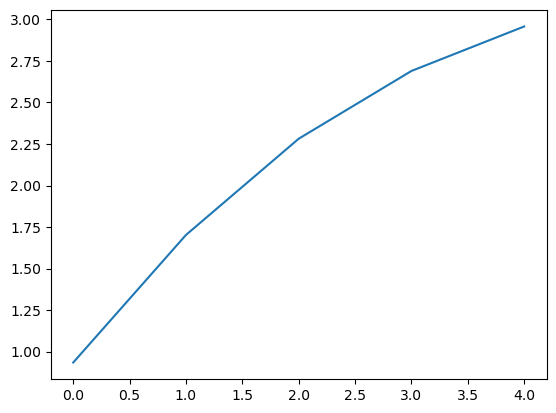

In [20]:
for i in range(xs.shape[1]):
    plt.plot(xs[:,i])
    plt.show()

In [33]:
next_x, *rest = vstep(x, u)

u before step:  Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = Array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)
  batch_dim = 0
xu after normalize:  Traced<ShapedArray(float32[6])>with<BatchTrace(level=1/0)> with
  val = Array([[ 1.0495945 ,  0.02626679,  0.02448151, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0495914 ,  0.02638063,  0.02454041, -0.2856912 , -0.00764657,
        -0.05065575],
       [ 1.0495932 ,  0.02631347,  0.02450566, -0.2856912 , -0.00764657,
        -0.05065575],
       ...,
       [-1.2601978 ,  1.2516291 ,  0.7923746 , -1.7508601 , -0.03508765,
        -0.05065575],
       [-1.1742424 ,  1.2924764 ,  0.5003118 , -1.7516361 , -0.03187837,
        -0.05065575],
       [-1.0561429 ,  1.3389567 ,  0.28491655, -1.752323  , -0.02988534,
        -0.05065575]], dtype=float32)
  batch_dim = 0
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost functio

In [13]:
titles = ['cos', 'sin', 'theta_dot', 'p_ee', 'v_ee']

In [14]:
low_ind = 100
high_ind = 1000+low_ind

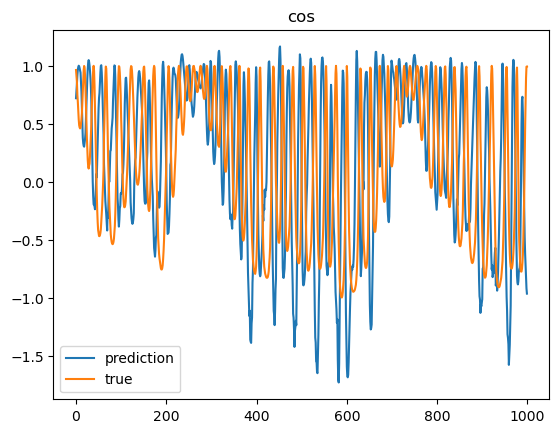

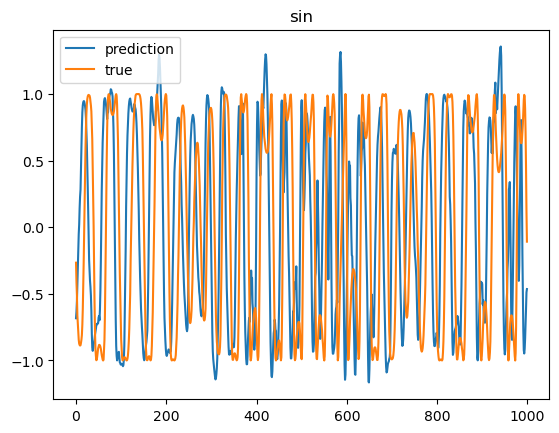

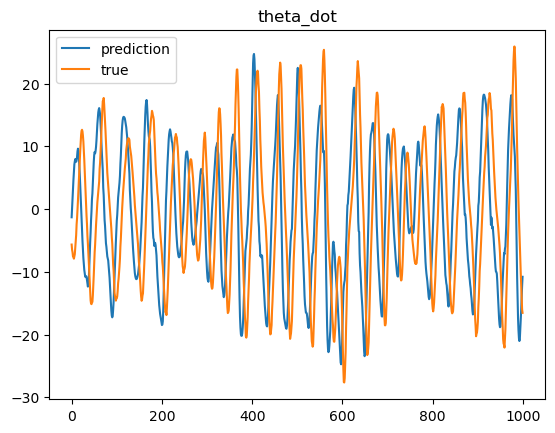

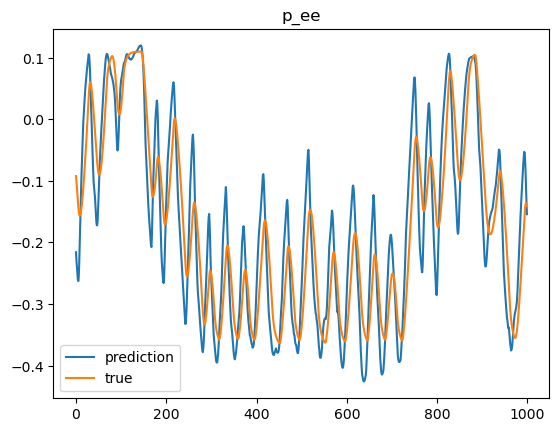

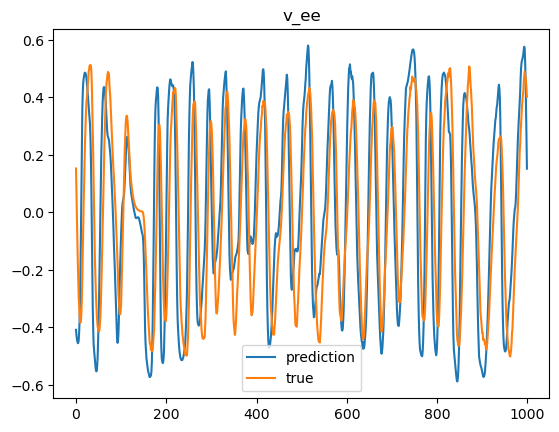

In [21]:

for i in range(next_x.shape[1]):
    plt.plot(next_x[low_ind:high_ind,i])
    plt.plot(x[low_ind+n_horizon:high_ind+n_horizon,i])
    plt.legend(["prediction", "true"])
    plt.title(titles[i])
    plt.show()

# Dynamics Model

In [3]:
import jax
import sys
sys.path.append('/home/honam/workspace/ode/pyur5/include/mbse')
sys.path.append('/home/honam/workspace/ode/pyur5/include/pyur5')

from mbse.agents.model_based.model_based_agent import ModelBasedAgent
from mbse.models.active_learning_model import ActiveLearningHUCRLModel
from mbse.utils.replay_buffer import ReplayBuffer
from gym.wrappers.rescale_action import RescaleAction
from gym.wrappers.time_limit import TimeLimit
from mbse.utils.vec_env.env_util import make_vec_env
from mbse.models.environment_models.pendulum_swing_up import CustomPendulumEnv, PendulumReward
import pickle 
import matplotlib.pyplot as plt
from models.ens_model import EnsembleModel
from gym.envs.classic_control.pendulum import angle_normalize
from mbse.models.ur5_dynamics_model import Ur5PendulumReward, Ur5PendulumDynamicsModel
import jax.numpy as jnp


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [15]:
model = EnsembleModel(use_cos=True)

obs_min [ -1.          -0.99999994 -27.60719     -0.3697316   -0.5656025 ]
obs_max [ 1.          1.         29.366909    0.11000495  0.5740574 ]
action_min [-0.6999999]
action_max [0.6999999]


In [4]:
dynamic_model = Ur5PendulumDynamicsModel()

obs_min [ -1.          -0.99999994 -27.60719     -0.3697316   -0.5656025 ]
obs_max [ 1.          1.         29.366909    0.11000495  0.5740574 ]
action_min [-0.6999999]
action_max [0.6999999]
target state: [3.1415927 0.       ]
cost weights: [1.e+01 1.e+00 1.e-03]


In [18]:
x_test, u_test, cost = model.forward_traj(x[0], 100)

(5,)
(100, 1)
(5,)
(1,)
u before step:  Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=3/0)>
xu after normalize:  Traced<ShapedArray(float32[6])>with<DynamicJaxprTrace(level=3/0)>
dx value of shape:  (5,)
x_next of shape:  (5,)
reward function called
cost function called
state shape:  (5,)
action shape:  (1,)
state:  Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=3/0)>
action:  Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=3/0)>
state shape:  (4,)
theta:  Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=3/0)>
x_next of dynamics_fn:  Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=3/0)>


(Array([[ 9.99998212e-01, -1.88807014e-03, -1.41605344e-02,
         -1.29997522e-01,  0.00000000e+00],
        [ 9.99870539e-01,  7.26578906e-02,  5.78796923e-01,
         -1.19880646e-01,  9.70117003e-02],
        [ 9.93923903e-01,  1.32019043e-01,  9.50009584e-01,
         -1.10873699e-01,  1.66382611e-01],
        [ 9.85883474e-01,  1.63440853e-01,  9.78281438e-01,
         -1.06007650e-01,  1.90705866e-01],
        [ 9.80604410e-01,  1.63680896e-01,  6.85513854e-01,
         -1.06463328e-01,  1.69121429e-01],
        [ 9.79425192e-01,  1.34755075e-01,  1.43531144e-01,
         -1.11758709e-01,  1.07933201e-01],
        [ 9.78666544e-01,  8.63327757e-02, -5.26975811e-01,
         -1.19857468e-01,  2.83848345e-02],
        [ 9.74156618e-01,  2.68327259e-02, -1.22141862e+00,
         -1.29149780e-01, -5.11057153e-02],
        [ 9.64454889e-01, -3.83991115e-02, -1.86869538e+00,
         -1.39075965e-01, -1.23207584e-01],
        [ 9.49373484e-01, -9.81110632e-02, -2.32199311e+00,
    

In [14]:
dynamic_model.reward_model.predict(x, u)

reward function called
cost function called
state shape:  (13138, 5)
action shape:  (13138, 1)
state:  Traced<ShapedArray(float32[13138,5])>with<DynamicJaxprTrace(level=1/0)>
action:  Traced<ShapedArray(float32[13138,1])>with<DynamicJaxprTrace(level=1/0)>


AssertionError: 

# Metadata

In [41]:
with open("../../metadata/metadata_False.pkl", "rb") as f:
    metadata = pickle.load(f)

In [42]:
metadata

{'mu_x': Array([-0.00228791, -0.05982549, -0.0918825 ,  0.00232682,  0.02780968],      dtype=float32),
 'std_x': Array([ 1.4142525 , 10.060761  ,  0.13341333,  0.30429524,  0.5489935 ],      dtype=float32),
 'mu_y': Array([-9.7091385e-04,  7.1468449e-04,  1.0873447e-06,  4.9895600e-05],      dtype=float32),
 'std_y': Array([0.18088467, 1.4138476 , 0.00833599, 0.04515266], dtype=float32),
 'min_x': Array([ -3.1408057, -27.60719  ,  -0.3697316,  -0.5656025,  -0.6999999],      dtype=float32),
 'max_x': Array([ 3.1414158 , 29.366909  ,  0.11000495,  0.5740574 ,  0.6999999 ],      dtype=float32)}

In [43]:
with open("../../metadata/metadata_True.pkl", "rb") as f:
    metadata = pickle.load(f)

In [44]:
metadata

{'mu_x': Array([ 0.32547095,  0.00663646, -0.05982549, -0.0918825 ,  0.00232682,
         0.02780968], dtype=float32),
 'std_x': Array([ 0.6423623 ,  0.69382656, 10.060761  ,  0.13341333,  0.30429524,
         0.5489935 ], dtype=float32),
 'mu_y': Array([-4.09764925e-06,  1.17967065e-05,  7.14684487e-04,  1.08734469e-06,
         4.98955997e-05], dtype=float32),
 'std_y': Array([0.12171613, 0.13206616, 1.4138476 , 0.00833599, 0.04515266],      dtype=float32),
 'min_x': Array([ -1.        ,  -0.99999994, -27.60719   ,  -0.3697316 ,
         -0.5656025 ,  -0.6999999 ], dtype=float32),
 'max_x': Array([ 1.        ,  1.        , 29.366909  ,  0.11000495,  0.5740574 ,
         0.6999999 ], dtype=float32)}